In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [2]:
import sys
import os

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")

In [3]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)
invalid_subjs = qa_records['invalid']

In [4]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 2), 'gaze_analysis', 'features')
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [5]:
def load_subj_behav_data(subj):
    behav_data = pd.read_csv(os.path.join(
        DEFAULT_FEATURE_FOLDER, str(subj), 'behavior.csv'), index_col=0)
    return behav_data

In [6]:
RESULTS_PATH = os.path.join(get_n_dir_up(CUR_PATH, 3), 'results')
PLOTS_FOLDER = os.path.join(RESULTS_PATH, 'images', 'behavior', 'behavior_gaze')

## Compare Draw v.s. Click

### convert response to distribution

In [7]:
def deg_signed_diff(d1, epoch=180):
    d2 = - np.sign(d1) * (epoch - np.abs(d1))
    mask = np.abs(d1) < np.abs(d2)
    d = mask * d1 + (~mask) * d2
    # finally, convert 90 to -90
    half_epoch = epoch // 2
    mask_90 = d == half_epoch
    d = mask_90 * (-half_epoch) + (~mask_90) * d
    return d

def df_to_errs(df, lmb):
    if lmb is not None:
        mask = lmb(df)
        if np.sum(mask) == 0:
            return None
        df = df[mask]    

    # tease out stim 1 and stim 2
    stims = np.concatenate([
        df['stim_1'].to_numpy(copy=True),
        df['stim_2'].to_numpy(copy=True)
    ])
    non_target = np.concatenate([
        df['stim_2'].to_numpy(copy=True),
        df['stim_1'].to_numpy(copy=True)
    ])
    resps = np.concatenate([
        df['resp_1'].to_numpy(copy=True),
        df['resp_2'].to_numpy(copy=True)
    ])
    subjects = np.concatenate([
        df['participant'].to_numpy(copy=True),
        df['participant'].to_numpy(copy=True)
    ])
    prev_resps = np.concatenate([
        df['prev_last_response'].to_numpy(copy=True),
        df['prev_last_response'].to_numpy(copy=True)
    ])
    # remove nan
    valid_mask = (~(np.isnan(resps))) & (~(np.isnan(prev_resps)))
    errs = deg_signed_diff(resps[valid_mask]-stims[valid_mask])
    subjects = subjects[valid_mask]
    stims = stims[valid_mask]
    non_target = non_target[valid_mask]
    prev_resps = prev_resps[valid_mask]
    # collect results
    results = pd.DataFrame({
        'subject': subjects,
        'stim': stims,
        'err': errs,
        'non_target': non_target,
        'prev_resp': prev_resps,
    })
    return results

In [8]:
example_df = load_subj_behav_data(908)
example_err_df = df_to_errs(example_df, None)

In [9]:
def errdf_to_distrib(err_df, T=180, ref=None):
    # convert err to distrib
    distrib = np.zeros(T)
    err_ids = err_df['err'].to_numpy().astype(int) 
    # flip to compare bias
    if ref is not None:
        ref_dir = deg_signed_diff(
            (err_df[ref] - err_df['stim']).to_numpy(), epoch=T)
        flip_mask = ref_dir < 0
        err_ids[flip_mask] = - err_ids[flip_mask]
    # get the aligned distribution
    err_ids = err_ids % T
    np.add.at(distrib, err_ids, 1)
    distrib = distrib / np.sum(distrib)
    return distrib

def compute_accuracy(distrib, T=180):
    # 0 --> err = 0
    # 0.5 --> max err
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.cos(np.deg2rad(errs))

    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)
    acc = np.sum(distrib_vec * baseline_vec, axis=-1)
    return acc

def compute_bias(distrib, T=180, err_thresh=40):
    # 0 --> no bias
    # 0.25 --> most positive bias
    # 0.5 --> neutral?
    # 0.75 --> most negative bias
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.sin(np.deg2rad(errs))

    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)

    # error filtering
    total_weights = np.linalg.norm(baseline_vec)
    if err_thresh is None:
        err_thresh = 180
    mask = np.abs(errs) <= (err_thresh * 360 / T)
    distrib_vec = distrib_vec[mask]
    baseline_vec = baseline_vec[mask]
    kept_weights = np.linalg.norm(baseline_vec)

    ratio = total_weights / kept_weights
    bias = np.sum(distrib_vec * baseline_vec, axis=-1) * ratio
    return bias

In [10]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

In [11]:
def get_stim_restrict_bias(common_lmb, center_sample, window_size):
    # collect errors
    err_dfs = []

    for subj in all_subjs:
        if subj in invalid_subjs:
            continue
        subj_df = load_subj_behav_data(subj)
        err_dfs.append(df_to_errs(subj_df, common_lmb))
    err_dfs = pd.concat(err_dfs, axis=0, ignore_index=True)

    # masked out by stims
    if window_size is not None:
        stim_within_range_mask = (
            np.abs(deg_signed_diff(err_dfs['stim'].values -center_sample)) <= window_size)
        err_dfs = err_dfs[stim_within_range_mask]

    # grouped by subject
    subj_accs = {}
    subj_bias = {}

    for subj, subjdf in err_dfs.groupby('subject'):
        # collect errors
        distrib = errdf_to_distrib(subjdf, T=180)
        # compute accuracy and bias
        acc = compute_accuracy(distrib, T=180)
        bias = compute_bias(distrib, T=180)
        # collect results
        subj_accs[subj] = acc
        subj_bias[subj] = bias

    return subj_accs, subj_bias

def display_acc_bias_as_tuning(common_lmb, condition_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sample_step = 15
    sample_xs = np.arange(int(180/sample_step)) * sample_step
    collected_sample_stats = []
    for sample_x in sample_xs:
        accs, biases = get_stim_restrict_bias(
            common_lmb=common_lmb,
            center_sample=sample_x,
            window_size=sample_step/2, # to match the gaze analysis
        )
        acc_mean = np.mean(list(accs.values()))
        acc_sem = np.std(list(accs.values())) / np.sqrt(len(accs))
        bias_mean = np.mean(list(biases.values()))
        bias_sem = np.std(list(biases.values())) / np.sqrt(len(biases))
        collected_sample_stats.append({
            'accuracy': {
                'mean': acc_mean,
                'sem': acc_sem,
            },
            'bias': {
                'mean': bias_mean,
                'sem': bias_sem,
            }
        })

    sample_xs = np.append(sample_xs, 180)
    collected_sample_stats.append(collected_sample_stats[0])
        
    for i, stat_name in enumerate(['accuracy', 'bias']):
        stats_mean = np.array([
            collected_sample_stats[i][stat_name]['mean'] for i in range(len(sample_xs))])
        stats_sem = np.array([
            collected_sample_stats[i][stat_name]['sem'] for i in range(len(sample_xs))])
        axs[i].errorbar(sample_xs, stats_mean, yerr=stats_sem, fmt='o', capsize=5)

        axs[i].set_xlabel('Stim Degree')
        axs[i].axvline(45, color='gray', linestyle='--', alpha=0.5)
        axs[i].axvline(90, color='gray', linestyle='--')
        axs[i].axvline(135, color='gray', linestyle='--', alpha=0.5)
        axs[i].axhline(0, color='red', linestyle='--')

        axs[i].set_xticks(sample_xs)

    axs[0].set_ylim([0, 3.5])
    # axs[0].set_yticks(np.arange(-0.1, 1.3, 0.2))
    axs[0].set_ylabel('accuracy', fontsize=14)
    axs[1].set_ylim([-2, 2])
    # axs[1].set_yticks(np.arange(-0.2, 0.3, 0.1))
    axs[1].set_ylabel('bias', fontsize=14)

    # save the result
    plt.tight_layout()
    plot_path = os.path.join(
        PLOTS_FOLDER, f'cardinal_oblique_{condition_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

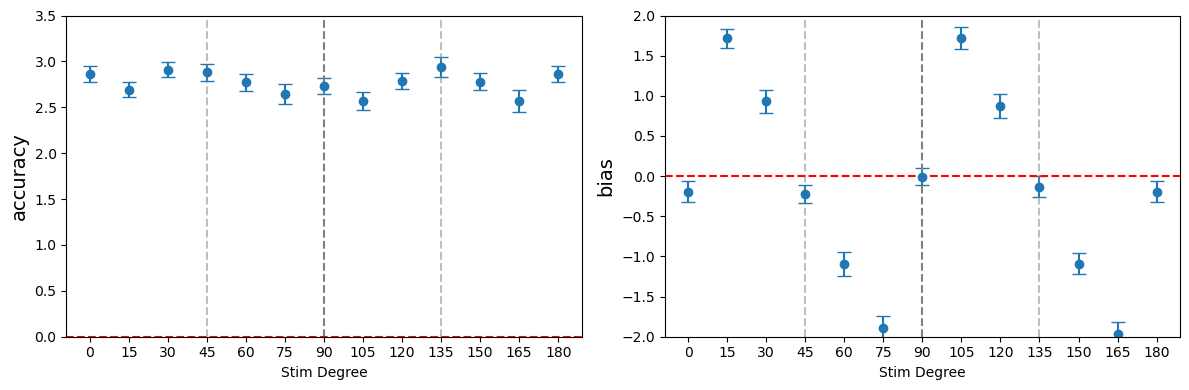

In [12]:
default_lmb = lambda d: np.ones(d.shape[0], dtype=bool)
display_acc_bias_as_tuning(default_lmb, 'all')

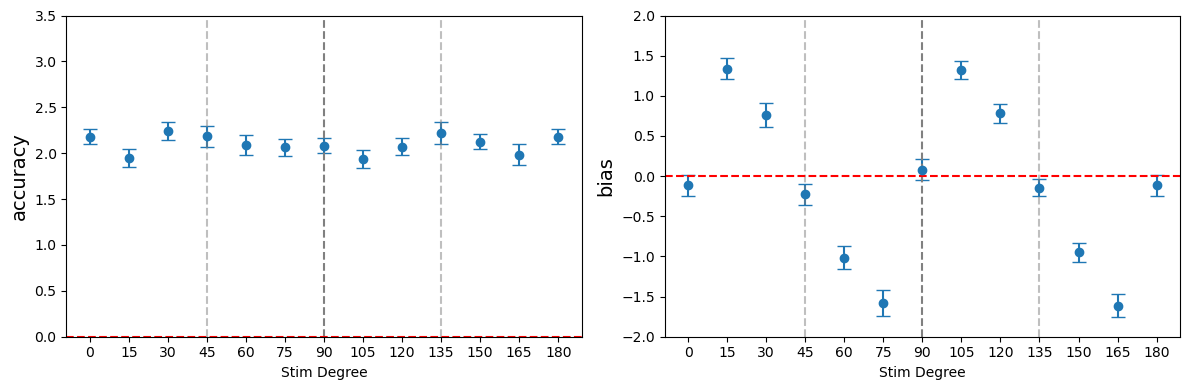

In [13]:
display_acc_bias_as_tuning(draw_lmb, 'draw')

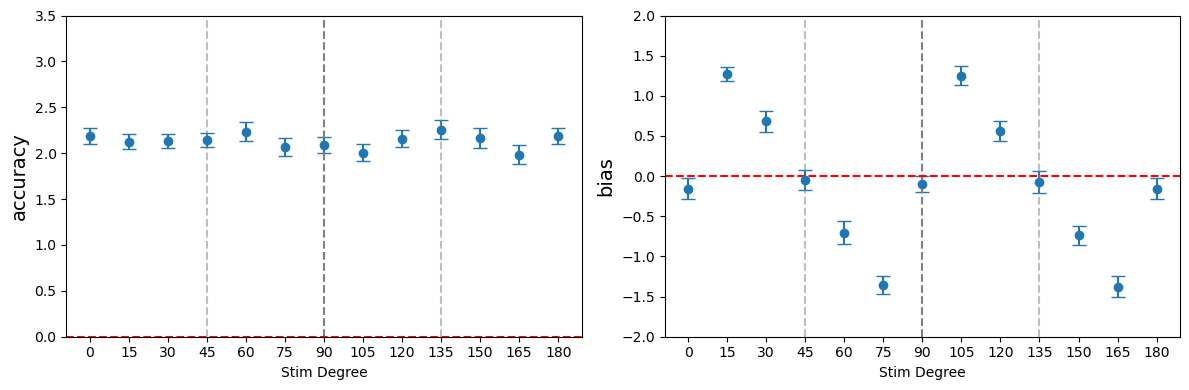

In [14]:
display_acc_bias_as_tuning(click_lmb, 'click')

### Get subjectwise behavior stats

In [15]:
def compute_subj_behav_stats(lmb, stat_type):
    collected = {}
    for subj in all_subjs:
        if subj in invalid_subjs:
            continue
        subj_df = load_subj_behav_data(subj)
        err_df = df_to_errs(subj_df, lmb)
        if err_df is None:
            # subject do not have enough data...
            continue
        ref_type = {
            'accuracy': None,
            'bias': None,
            'sd': 'prev_resp',
            'sur': 'non_target',
        }[stat_type]
        stat_func = compute_accuracy if stat_type == 'accuracy' else compute_bias
        distrib = errdf_to_distrib(err_df, T=180, ref=ref_type)
        stat = stat_func(distrib, T=180)
        collected[subj] = stat

    return collected
    

#### Firstly, check accuracy

In [16]:
subj_acc_stats = compute_subj_behav_stats(default_lmb, 'accuracy')
subj_draw_accs = compute_subj_behav_stats(draw_lmb, 'accuracy')
subj_click_accs = compute_subj_behav_stats(click_lmb, 'accuracy')

In [17]:
import statsmodels.api as sm

def display_regression(ax, l1, l2):
    x_with_const = sm.add_constant(l1)
    model = sm.OLS(l2, x_with_const).fit()
    predictions = model.get_prediction(x_with_const)
    summary_frame = predictions.summary_frame(alpha=0.05)

    # Get confidence intervals of the model
    conf_int = model.conf_int(alpha=0.05)

    # Get standard errors
    y_pred = summary_frame['mean']                 # Predicted values
    ci_lower = summary_frame['mean_ci_lower']      # Lower bound of confidence interval
    ci_upper = summary_frame['mean_ci_upper']

    # plot it
    order = np.argsort(l1)
    ax.plot(l1[order], y_pred[order], color='red', label=f'Regression Line: y={model.params[1]:.2f}x+{model.params[0]:.2f}')
    ax.fill_between(l1[order], ci_lower[order], ci_upper[order], color='gray', alpha=0.3)

    # show p value
    p_values = model.pvalues
    # print(p_values)
    return conf_int, p_values

def display_regression_with_plot(l1, l2, xlabel, ylabel, plot_name):
    _, ax = plt.subplots(1, figsize=(3, 3))
    ax.scatter(l1, l2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    _, pval = display_regression(ax, l1, l2)
    ax.set_title(f'p-val: {pval[1]:.4f}')

    # also mark the median
    median_x = np.median(l1)
    median_y = np.median(l2)
    ax.axvline(median_x, color='y', alpha=0.5, linestyle='--')
    ax.axhline(median_y, color='y', alpha=0.5, linestyle='--')

    plot_path = os.path.join(
        PLOTS_FOLDER, f'{plot_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

def dispalay_regression_dicts(dict1, dict2, xlabel, ylabel, plot_name):
    shared_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    l1 = np.array([dict1[k] for k in shared_keys])
    l2 = np.array([dict2[k] for k in shared_keys])
    display_regression_with_plot(l1, l2, xlabel, ylabel, plot_name)

##### load gaze acc

In [18]:
gaze_stats_path = os.path.join(
    RESULTS_PATH, 'stats', 'gaze', 'inverted_enc')

In [19]:
DEFAULT_BEHAV_THRESH = 3.5
DEFAULT_GAZE_THRESH = 0.0

In [20]:
def load_acc_stats(gaze_stats_name):
        gaze_acc_path = os.path.join(gaze_stats_path, gaze_stats_name, 'accuracy.json')
        with open(gaze_acc_path) as f:
                gaze_acc = json.load(f)
        if 'combined' in gaze_acc:
                gaze_acc = gaze_acc['combined']['accuracy']
        else:
                gaze_acc = gaze_acc['stim 1']['accuracy']
        return gaze_acc

def compare_gaze_behav_acc(gaze_stats_name, behav_stats, plot_name,
                gaze_acc_thresh=DEFAULT_GAZE_THRESH, behav_acc_thresh=DEFAULT_BEHAV_THRESH):
        gaze_acc = load_acc_stats(gaze_stats_name)
        # filter by accuracy
        gaze_acc = {k: v for k, v in gaze_acc.items() if v > gaze_acc_thresh}
        behav_stats = {k: v for k, v in behav_stats.items() if v > behav_acc_thresh}

        # compare gaze and behav
        dispalay_regression_dicts(
                gaze_acc, behav_stats,
                'Gaze Accuracy', 'Behavior Accuracy',
                plot_name)


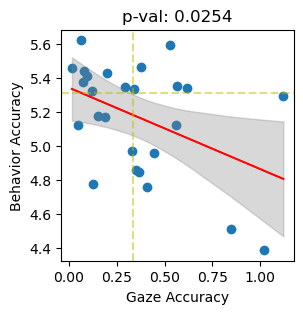

In [21]:
compare_gaze_behav_acc(
    'whole_isi_combined', subj_acc_stats, 'reg_behav_gaze_isi_acc')

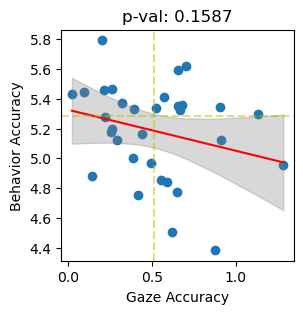

In [22]:
compare_gaze_behav_acc(
    'whole_delay_combined', subj_acc_stats, 'reg_behav_gaze_delay_acc')

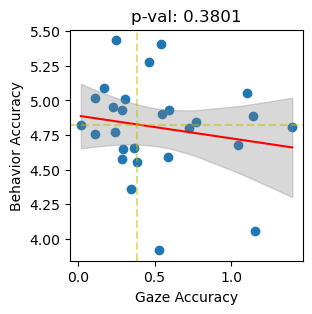

In [23]:
compare_gaze_behav_acc(
    'whole_delay_draw2draw', subj_draw_accs, 
    'reg_draw_behav_gaze_delay_acc')

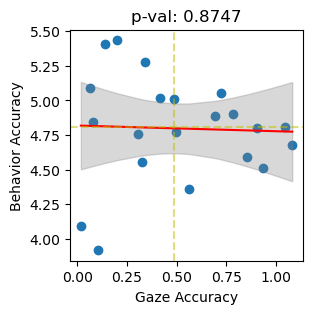

In [24]:
compare_gaze_behav_acc(
    'delay_first_phase_draw2draw', subj_draw_accs, 
    'reg_draw_behav_gaze_delay_start_acc')

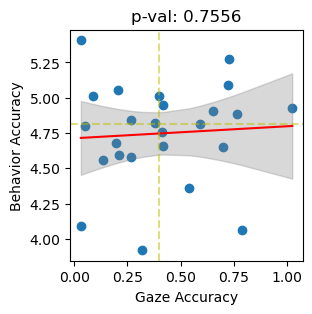

In [25]:
compare_gaze_behav_acc(
    'delay_last_phase_draw2draw', subj_draw_accs, 
    'reg_draw_behav_gaze_delay_end_acc')

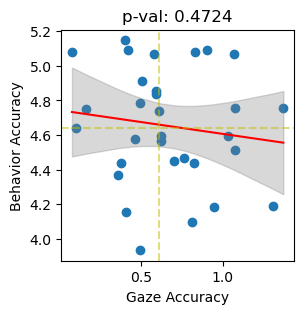

In [26]:
compare_gaze_behav_acc(
    'whole_delay_click2click', subj_click_accs, 
    'reg_click_behav_gaze_delay_acc')

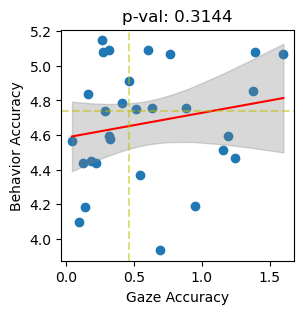

In [27]:
compare_gaze_behav_acc(
    'delay_first_phase_click2click', subj_click_accs, 
    'reg_click_behav_gaze_delay_start_acc')

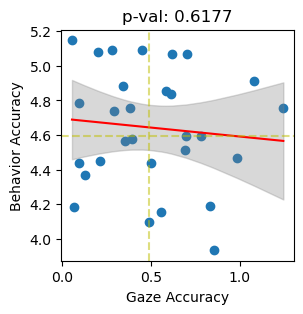

In [28]:
compare_gaze_behav_acc(
    'delay_last_phase_click2click', subj_click_accs, 
    'reg_click_behav_gaze_delay_end_acc')

#### serial bias

In [29]:
def compare_gaze_behav_sd_bias(gaze_stats_name, behav_stats, plot_name, acc_filter=False):
    gaze_bias_path = os.path.join(gaze_stats_path, gaze_stats_name, 'sd.json')
    with open(gaze_bias_path) as f:
        gaze_bias = json.load(f)
    if 'combined' in gaze_bias:
        gaze_bias = gaze_bias['combined']['bias']
    else:
        gaze_bias = gaze_bias['stim 1']['bias']

    # remove those of acc below baseline
    if acc_filter:
        gaze_acc_path = os.path.join(
            gaze_stats_path, gaze_stats_name, 'accuracy.json')
        with open(gaze_acc_path) as f:
            gaze_acc = json.load(f)
        if 'combined' in gaze_acc:
            gaze_acc = gaze_acc['combined']['accuracy']
        else:
            gaze_acc = gaze_acc['stim 1']['accuracy']
        gaze_bias = {k:v for k,v in gaze_bias.items() 
            if gaze_acc[k] > DEFAULT_GAZE_THRESH}
        behav_stats = {k:v for k,v in behav_stats.items()
            if subj_acc_stats[k] > DEFAULT_BEHAV_THRESH}

    # compare gaze and behav
    dispalay_regression_dicts(
        gaze_bias, behav_stats,
        'Gaze Serial Bias', 'Behavior Serial Bias',
        plot_name)

In [30]:
subj_sd_stats = compute_subj_behav_stats(default_lmb, 'sd')
subj_draw_sds = compute_subj_behav_stats(draw_lmb, 'sd')
subj_click_sds = compute_subj_behav_stats(click_lmb, 'sd')

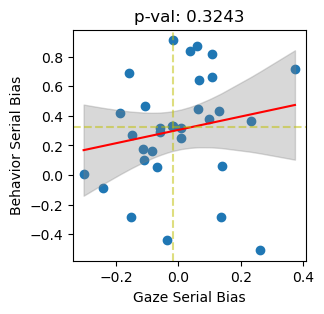

In [31]:
compare_gaze_behav_sd_bias(
    'whole_delay_combined', subj_sd_stats, 
    'reg_behav_gaze_delay_sd',
    acc_filter=True)

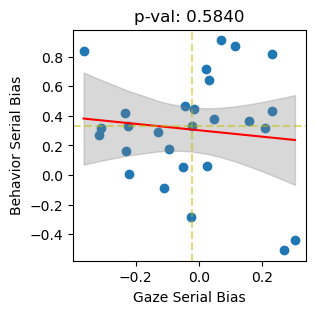

In [32]:
compare_gaze_behav_sd_bias(
    'whole_delay_draw2draw', subj_sd_stats, 
    'reg_behav_gaze_draw_delay_sd',
    acc_filter=True)

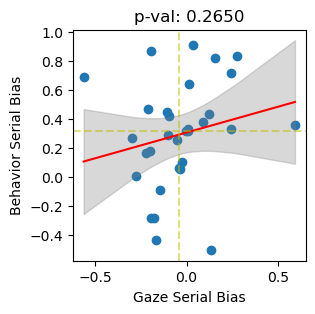

In [33]:
compare_gaze_behav_sd_bias(
    'whole_delay_click2click', subj_sd_stats, 
    'reg_behav_gaze_click_delay_sd',
    acc_filter=True)

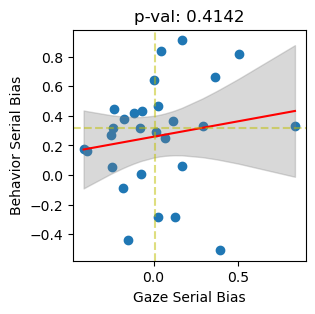

In [34]:
compare_gaze_behav_sd_bias(
    'delay_last_phase_combined', subj_sd_stats, 
    'reg_behav_gaze_delay_end_sd',
    acc_filter=True)

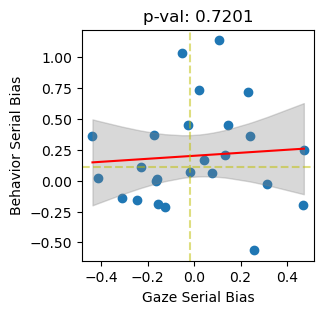

In [35]:
compare_gaze_behav_sd_bias(
    'delay_last_phase_draw2draw', subj_draw_sds, 
    'reg_draw_behav_gaze_delay_end_sd',
    acc_filter=True)

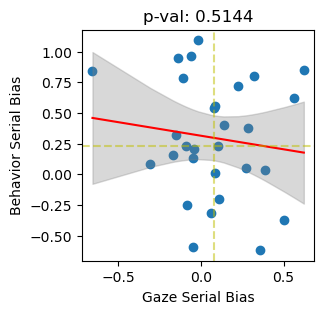

In [36]:
compare_gaze_behav_sd_bias(
    'delay_last_phase_click2click', subj_click_sds, 
    'reg_click_behav_gaze_delay_end_sd',
    acc_filter=True)

**comments**: unfortunately...

##### Try taking the average over the end of delay...

In [37]:
TRIAL_TIMEPOINT_PRED_PATH = os.path.join(gaze_stats_path, 'predictions')

In [119]:
last_phase_ids = [8, 9, 10]
def load_avg_preds(mode, phase_ids, lmb, align_type):
    mode_path = os.path.join(TRIAL_TIMEPOINT_PRED_PATH, f'{mode}_delay_phase')
    df = pd.read_csv(os.path.join(mode_path, 'y_df.csv'), index_col=0)
    select_mask = lmb(df) if lmb is not None else np.ones(df.shape[0], dtype=bool)
    stim_masks = {
        'stim_1': select_mask.copy(),
        'stim_2': select_mask.copy(),
    }
    preds = [[], []]
    for pid in phase_ids:
        for i, stim_id in enumerate(['stim_1', 'stim_2']):
            loaded = np.load(
                os.path.join(mode_path, f'phase_{pid}', 
                    'aligned', stim_id, f'{align_type}.npy'), 
                allow_pickle=True)
            load_valid_mask = (~(np.isnan(loaded[:, 0]))) & stim_masks[stim_id]
            stim_masks[stim_id] = stim_masks[stim_id] & load_valid_mask
            # print(np.sum(select_mask))
            preds[i].append(loaded[load_valid_mask])
    preds = [np.mean(ps, axis=0) for ps in preds]
    dfs = [df[stim_masks[stim_id]] for stim_id in ['stim_1', 'stim_2']]
    return dfs, preds

In [120]:
draw_last_phase_target_avg = load_avg_preds('draw', last_phase_ids, None, 'target')
click_last_phase_target_avg = load_avg_preds('click', last_phase_ids, None, 'target')

In [121]:
draw_last_phase_prev_avg = load_avg_preds('draw', last_phase_ids, None, 'previous')
click_last_phase_prev_avg = load_avg_preds('click', last_phase_ids, None, 'previous')

In [122]:
def last_phase_avg_to_stats(df, avg_preds, stat_type, acc_thresh=DEFAULT_GAZE_THRESH):
    # we don't care stim 1 or 2 just collapse them
    df = pd.concat((df[0], df[1]), axis=0, ignore_index=True)
    avg_preds = np.concatenate((avg_preds[0], avg_preds[1]), axis=0)

    subjects = df['participant'].to_numpy()
    all_subj_stats = {}
    for subj in all_subjs:
        subj_mask = subjects == int(subj)
        if np.sum(subj_mask) == 0:
            # subject do not have enough data...
            continue
        subj_preds = avg_preds[subj_mask]
        subj_distrib = np.mean(subj_preds, axis=0)
        subj_distrib = subj_distrib / np.sum(subj_distrib)
        stat_func = compute_accuracy if stat_type == 'accuracy' else compute_bias
        stat = stat_func(subj_distrib, T=180)
        all_subj_stats[subj] = stat

    if acc_thresh is not None:
        # remove those of acc below baseline
        all_subj_stats = {k: v for k, v in all_subj_stats.items() 
            if subj_acc_stats[k] > acc_thresh}

    return all_subj_stats

In [123]:
gaze_draw_last_phase_avg_acc = last_phase_avg_to_stats(
    draw_last_phase_target_avg[0], 
    draw_last_phase_target_avg[1],
    'accuracy'
)

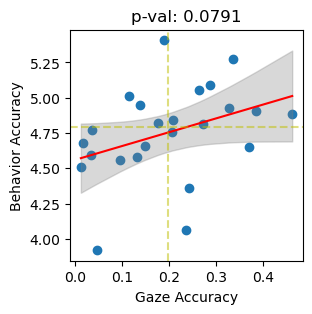

In [124]:
gacc = {k:v for k, v in gaze_draw_last_phase_avg_acc.items() if v > DEFAULT_GAZE_THRESH}
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    gacc, bacc,
    'Gaze Accuracy', 'Behavior Accuracy',
    'reg_draw_last_phase_avg_acc')

In [125]:
gaze_draw_last_phase_avg_sd = last_phase_avg_to_stats(
    draw_last_phase_prev_avg[0], 
    draw_last_phase_prev_avg[1],
    'bias'
)

In [126]:
gaze_click_last_phase_avg_sd = last_phase_avg_to_stats(
    click_last_phase_prev_avg[0], 
    click_last_phase_prev_avg[1],
    'bias'
)

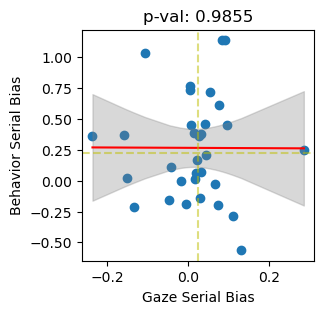

In [127]:
gsd = gaze_draw_last_phase_avg_sd
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
bsd = {k:subj_draw_sds[k] for k in bacc}
dispalay_regression_dicts(
    gsd, bsd,
    'Gaze Serial Bias', 'Behavior Serial Bias',
    'reg_draw_last_phase_avg_sd')

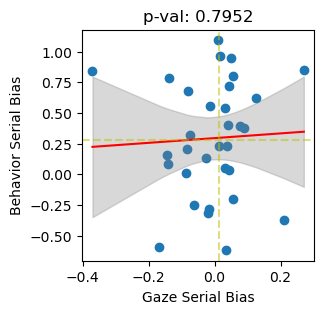

In [128]:
gsd = gaze_click_last_phase_avg_sd
bacc = {k:v for k, v in subj_click_accs.items() if v > DEFAULT_BEHAV_THRESH}
bsd = {k:subj_click_sds[k] for k in bacc}
dispalay_regression_dicts(
    gsd, bsd,
    'Gaze Serial Bias', 'Behavior Serial Bias',
    'reg_click_last_phase_avg_sd')

##### check if there are some interaction between acc and sd...

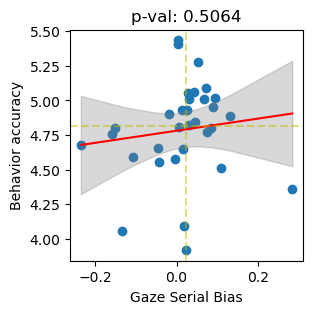

In [48]:
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    gaze_draw_last_phase_avg_sd, 
    bacc,
    'Gaze Serial Bias', 
    'Behavior accuracy', 
    'reg_behav_acc_draw_gaze_sd')

# one subject kicked out for bad performance (outlier, below 3.5)

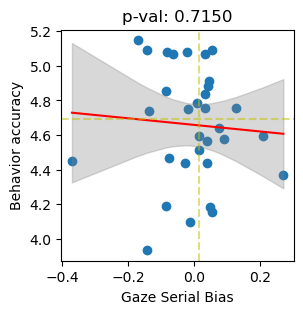

In [49]:
bacc = {k:v for k, v in subj_click_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    gaze_click_last_phase_avg_sd, 
    bacc,
    'Gaze Serial Bias', 
    'Behavior accuracy', 
    'reg_behav_acc_click_gaze_sd')

##### lastly, does accuracy has anything to do with SD in behavior?

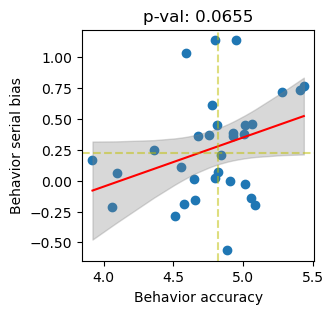

In [50]:
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    bacc, 
    subj_draw_sds,
    'Behavior accuracy', 
    'Behavior serial bias', 
    'reg_draw_behav_acc_sd')

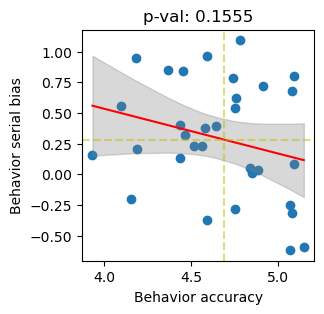

In [51]:
bacc = {k:v for k, v in subj_click_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    bacc, 
    subj_click_sds,
    'Behavior accuracy', 
    'Behavior serial bias', 
    'reg_click_behav_acc_sd')

#### Not really behavior analysis but we make use of the code here...

In [52]:
bacc = {k:v for k, v in subj_acc_stats.items() if v > DEFAULT_BEHAV_THRESH}

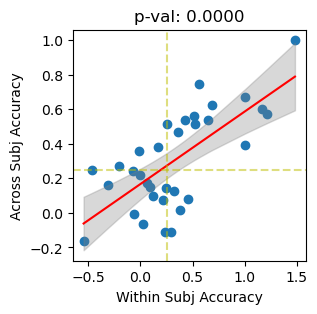

In [53]:
acc_within_subj_enc = load_acc_stats('within_subj_enc1_after_cue_combined')
acc_across_subj_enc = load_acc_stats('enc1_after_cue_combined')

dispalay_regression_dicts(
    acc_within_subj_enc, 
    acc_across_subj_enc,
    'Within Subj Accuracy', 
    'Across Subj Accuracy', 
    'reg_enc_within_vs_across_subj')

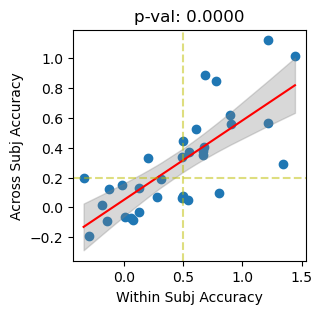

In [54]:
acc_within_subj_enc = load_acc_stats('within_subj_isi_combined')
acc_across_subj_enc = load_acc_stats('whole_isi_combined')

dispalay_regression_dicts(
    acc_within_subj_enc, 
    acc_across_subj_enc,
    'Within Subj Accuracy', 
    'Across Subj Accuracy', 
    'reg_isi_within_vs_across_subj')

##### Does across phase decoding quality has anything to do with behavior?

##### firstly, does the cross phase accuracy has any correlation?

In [55]:
acc_enc = load_acc_stats('enc1_after_cue_combined')
acc_enc_isi = load_acc_stats('enc1_isi_combined')
acc_enc_delay = load_acc_stats('enc1_delay_combined')
acc_isi = load_acc_stats('whole_isi_combined')
acc_isi_delay = load_acc_stats('isi_delay_combined')
acc_delay = load_acc_stats('whole_delay_combined')

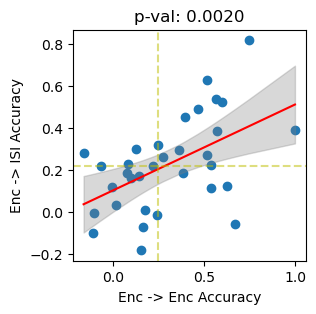

In [56]:
dispalay_regression_dicts(
    acc_enc, 
    acc_enc_isi,
    'Enc -> Enc Accuracy', 
    'Enc -> ISI Accuracy', 
    'reg_enc_vs_enc_isi')

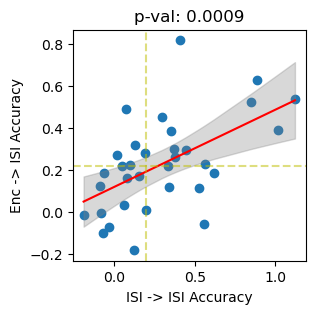

In [57]:
dispalay_regression_dicts(
    acc_isi, 
    acc_enc_isi,
    'ISI -> ISI Accuracy', 
    'Enc -> ISI Accuracy', 
    'reg_isi_vs_enc_isi')

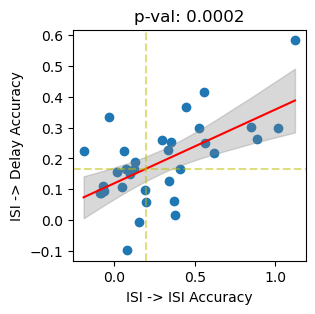

In [58]:
dispalay_regression_dicts(
    acc_isi, 
    acc_isi_delay,
    'ISI -> ISI Accuracy', 
    'ISI -> Delay Accuracy',
    'reg_isi_vs_isi_delay')

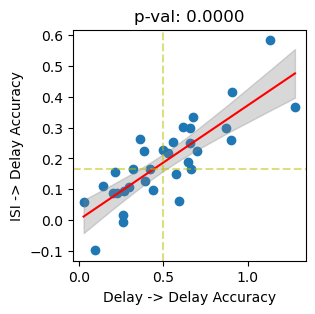

In [59]:
dispalay_regression_dicts(
    acc_delay, 
    acc_isi_delay,
    'Delay -> Delay Accuracy', 
    'ISI -> Delay Accuracy',
    'reg_delay_vs_isi_delay')

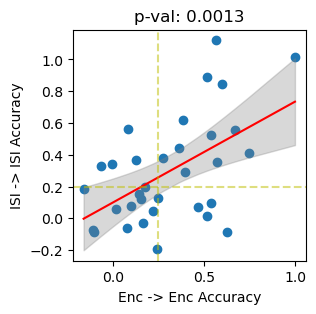

In [60]:
dispalay_regression_dicts(
    acc_enc,
    acc_isi,
    'Enc -> Enc Accuracy',
    'ISI -> ISI Accuracy',
    'reg_enc_vs_isi')

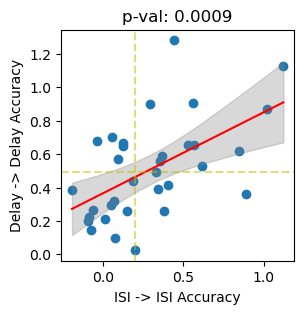

In [61]:
dispalay_regression_dicts(
    acc_isi,
    acc_delay,
    'ISI -> ISI Accuracy',
    'Delay -> Delay Accuracy', 
    'reg_isi_vs_delay')

##### Secondly, do any of these newly added acc has anything to do with behavior performance?

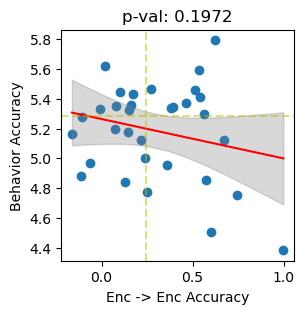

In [62]:
dispalay_regression_dicts(
    acc_enc, 
    bacc,
    'Enc -> Enc Accuracy', 
    'Behavior Accuracy', 
    'reg_enc_vs_behav')

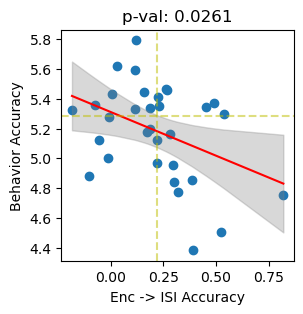

In [63]:
dispalay_regression_dicts(
    acc_enc_isi, 
    bacc,
    'Enc -> ISI Accuracy', 
    'Behavior Accuracy', 
    'reg_enc_isi_vs_behav')

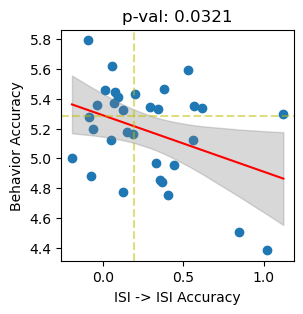

In [64]:
dispalay_regression_dicts(
    acc_isi, 
    bacc,
    'ISI -> ISI Accuracy', 
    'Behavior Accuracy', 
    'reg_isi_vs_behav')

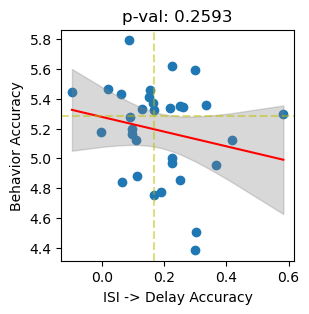

In [65]:
dispalay_regression_dicts(
    acc_isi_delay, 
    bacc,
    'ISI -> Delay Accuracy', 
    'Behavior Accuracy', 
    'reg_isi_delay_vs_behav')

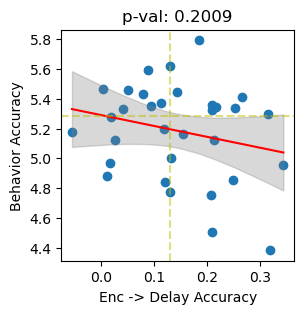

In [66]:
dispalay_regression_dicts(
    acc_enc_delay, 
    bacc,
    'Enc -> Delay Accuracy', 
    'Behavior Accuracy', 
    'reg_enc_delay_vs_behav')

**Comments** 

- Again None of them show any significant relationship with behavioral performance....
- But their are correlations between eye decodability at different phases.

## What about hand motions?

In [67]:
hand_stats_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'stats',
    'mouse', 'inverted_enc')

with open(os.path.join(hand_stats_path, 'draw', 'accuracy.json')) as f:
    hand_draw_acc = json.load(f)
    hand_draw_acc = hand_draw_acc['combined']['accuracy']

with open(os.path.join(hand_stats_path, 'click', 'accuracy.json')) as f:
    hand_click_acc = json.load(f)
    hand_click_acc = hand_click_acc['combined']['accuracy']


In [68]:
gaze_draw_acc = load_acc_stats('whole_delay_draw2draw')
gaze_click_acc = load_acc_stats('whole_delay_click2click')

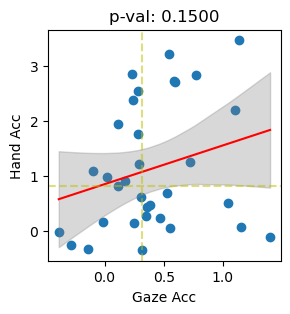

In [69]:
dispalay_regression_dicts(
    gaze_draw_acc, 
    hand_draw_acc,
    'Gaze Acc',
    'Hand Acc', 
    'reg_gaze_vs_hand_draw_acc')

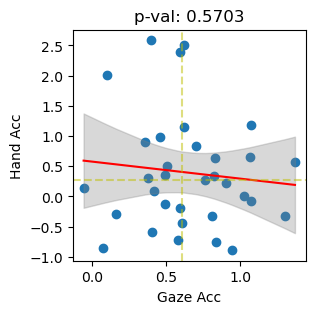

In [70]:
dispalay_regression_dicts(
    gaze_click_acc, 
    hand_click_acc,
    'Gaze Acc',
    'Hand Acc', 
    'reg_gaze_vs_hand_click_acc')

## Pull out survey questions

In [71]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [72]:
from utils.survey import preprocess_survey

survey_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'survey', 'survey_25Apr.csv')
survey_df = pd.read_csv(survey_path)
survey_df = preprocess_survey(survey_df)
survey_df['subject'] = survey_df.index.astype(str)
survey_df.reset_index(drop=True, inplace=True)

In [73]:
# keep only those in target subject list
target_survey = survey_df[survey_df['subject'].isin(all_subjs)]

### first check the strategy question

In [74]:
def plot_one_question(ax, df, qname, label_map, xmax=12):
    # label map: mapping numeric label to text
    labels, counts = np.unique(df[qname], return_counts=True)
    counts = {k:v for k,v in zip(labels, counts)}
    labels_sorted = [label for label in label_map.keys()] # if label in labels
    counts_sorted = [
        counts.get(label, 0) for label in labels_sorted]
    captions = [label_map[label] for label in labels_sorted]
    ax.barh(captions, counts_sorted, color='skyblue')
    for i, count in enumerate(counts_sorted):
        ax.text(count+0.8*xmax/10, i, str(count), va='center', ha='right')
    ax.set_yticks(np.arange(len(captions)))
    ax.set_yticklabels(captions)
    ax.invert_yaxis()
    if xmax is not None:
        ax.set_xlim([0, xmax])
    ax.set_xticks([])

In [75]:
from collections import OrderedDict

def plot_strategy_questions(survey_data, xmax=20):
    questions = OrderedDict([
        ('Q1.2', 'draw, null cue'),
        ('Q1.3', 'draw, informatic cue'),
        ('Q1.4', 'click, null cue'),
        ('Q1.5', 'click, informatic cue'),
    ])

    fig, axs = plt.subplots(1, len(questions), figsize=(4*len(questions), 3))
    for plot_id, qname in enumerate(list(questions.keys())):
        label_map = OrderedDict([
            (1, 'pictorial'), 
            (2, 'abstract'), 
            (3, 'action'), 
            # (4, 'mixed'), 
            # (5, 'other'),
        ])
        plot_one_question(axs[plot_id], survey_data, qname, label_map, xmax=xmax)
        axs[plot_id].set_title(questions[qname])
    plt.tight_layout()

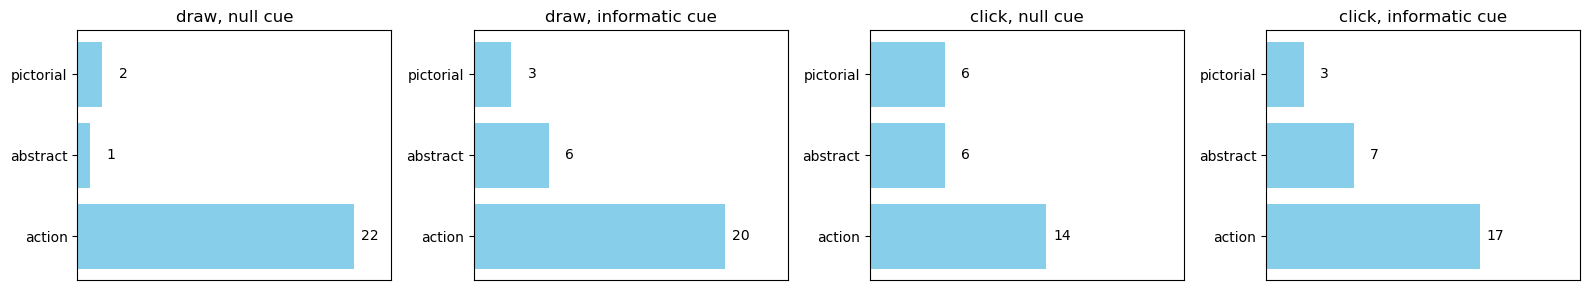

In [76]:
plot_strategy_questions(target_survey, xmax=25)
plot_path = os.path.join(
    PLOTS_FOLDER, 'strategy_questions.png')
plt.savefig(plot_path, bbox_inches='tight')

#### do strategies preference affect the accuracy?

In [77]:
strategy_dicts = target_survey[['Q1.2', 'Q1.3', 'Q1.4', 'Q1.5', 'subject']].to_dict(orient='records')

In [78]:
def collect_multi_question_scores(dicts, qs, score_func):
    scores = {}
    for rec in dicts:
        s = [score_func(rec[q]) for q in qs]
        s = [s1 for s1 in s if s1 is not None]
        if len(s) == 0:
            continue
        s = np.mean(s)
        scores[rec['subject']] = s
    return scores

In [79]:
stat_q_score_func = lambda x: (x if x <=3 else None)
draw_action_survey_scores = collect_multi_question_scores(
    strategy_dicts, ['Q1.2', 'Q1.3'], stat_q_score_func)

In [80]:
click_action_survey_scores = collect_multi_question_scores(
    strategy_dicts, ['Q1.4', 'Q1.5'], stat_q_score_func)

In [81]:
all_action_survey_scores = collect_multi_question_scores(
    strategy_dicts, ['Q1.2', 'Q1.3', 'Q1.4', 'Q1.5'], stat_q_score_func)

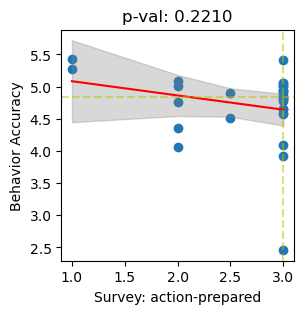

In [82]:
dispalay_regression_dicts(
    draw_action_survey_scores,
    subj_draw_accs,
    'Survey: action-prepared', 
    'Behavior Accuracy', 
    'reg_draw_q1_vs_behav')

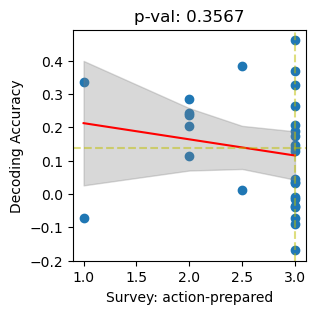

In [83]:
dispalay_regression_dicts(
    draw_action_survey_scores,
    gaze_draw_last_phase_avg_acc,
    'Survey: action-prepared', 
    'Decoding Accuracy', 
    'reg_draw_q1_vs_gaze_acc')

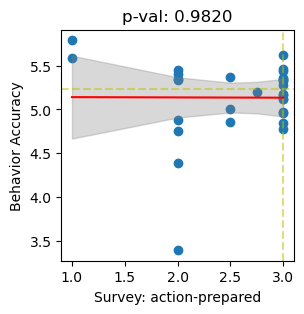

In [84]:
dispalay_regression_dicts(
    all_action_survey_scores,
    subj_acc_stats,
    'Survey: action-prepared', 
    'Behavior Accuracy', 
    'reg_q1_vs_behav')

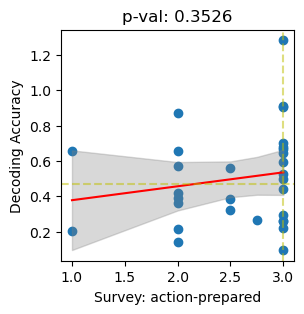

In [85]:
dispalay_regression_dicts(
    all_action_survey_scores,
    acc_delay,
    'Survey: action-prepared', 
    'Decoding Accuracy', 
    'reg_q1_vs_gaze_acc_delay')

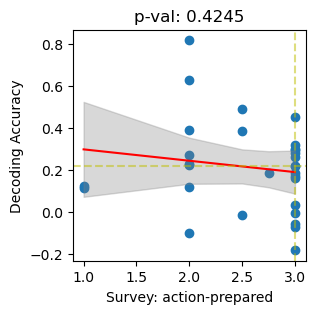

In [86]:
dispalay_regression_dicts(
    all_action_survey_scores,
    acc_enc_isi,
    'Survey: action-prepared', 
    'Decoding Accuracy', 
    'reg_q1_vs_gaze_acc_enc_isi')

**comment**: hehe

### Next we extract their answers to imagery question

In [87]:
def collect_imagery_question_scores(dicts, q, n_choices):
    scores = {}
    w = (n_choices + 1) / 2
    for rec in dicts:
        s = rec[q]
        s = (s - w) / w
        s = -s # originall smaller means more imagery
        scores[rec['subject']] = s
    return scores

In [88]:
imagery_dicts = target_survey[['Q6', 'Q7', 'subject']].to_dict(orient='records')

In [89]:
imagery_6_scores = collect_imagery_question_scores(imagery_dicts, 'Q6', 5)
imagery_7_scores = collect_imagery_question_scores(imagery_dicts, 'Q7', 3)

In [90]:
imagery_scores = {s: (imagery_6_scores[s] + imagery_7_scores[s])/2 for s in all_subjs}

#### Any correlation between questions?

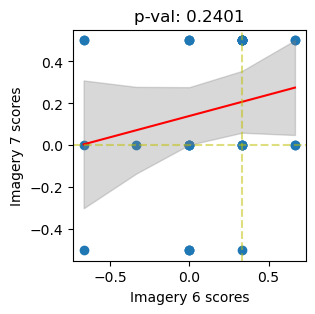

In [91]:
dispalay_regression_dicts(
    imagery_6_scores,
    imagery_7_scores,
    'Imagery 6 scores',
    'Imagery 7 scores', 
    'reg_q6_vs_q7')

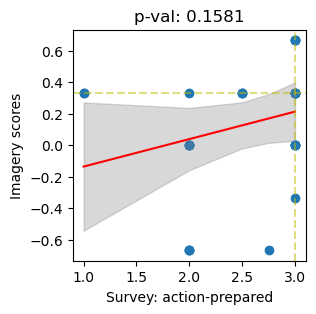

In [92]:
dispalay_regression_dicts(
    all_action_survey_scores,
    imagery_6_scores,
    'Survey: action-prepared', 
    'Imagery scores', 
    'reg_q1_vs_q6')

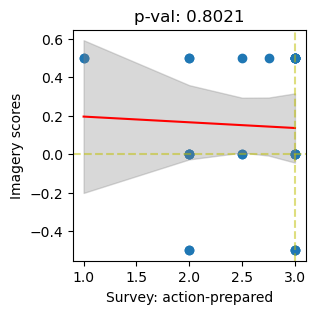

In [93]:
dispalay_regression_dicts(
    all_action_survey_scores,
    imagery_7_scores,
    'Survey: action-prepared', 
    'Imagery scores', 
    'reg_q1_vs_q7')

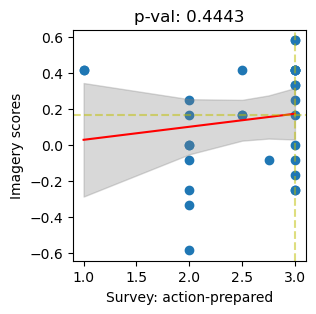

In [94]:
dispalay_regression_dicts(
    all_action_survey_scores,
    imagery_scores,
    'Survey: action-prepared', 
    'Imagery scores', 
    'reg_q1_vs_q6q7')

#### How about these question with gaze decoding accuracy?

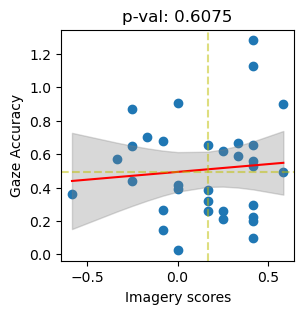

In [95]:
dispalay_regression_dicts(
    imagery_scores,
    acc_delay,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_delay')

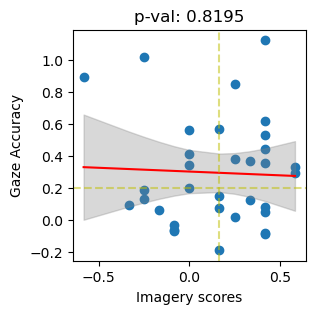

In [96]:
dispalay_regression_dicts(
    imagery_scores,
    acc_isi,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_isi')

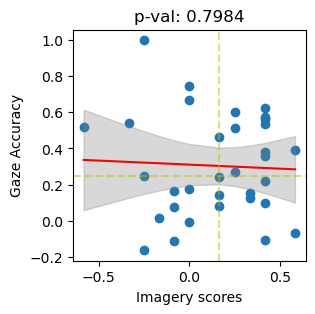

In [97]:
dispalay_regression_dicts(
    imagery_scores,
    acc_enc,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_enc')

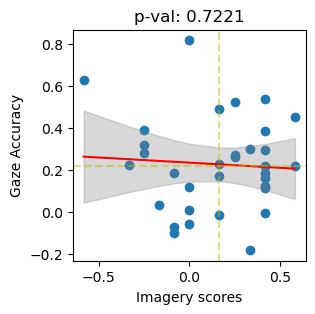

In [98]:
dispalay_regression_dicts(
    imagery_scores,
    acc_enc_isi,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_enc_isi')

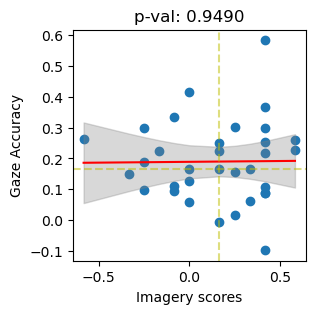

In [99]:
dispalay_regression_dicts(
    imagery_scores,
    acc_isi_delay,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_isi_delay')